In [1]:
import pandas as pd 
import numpy as np 
import datetime 
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
business = pd.read_csv('yelp_academic_dataset_business.csv')

/Users/srai/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,4,7,17,26,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
business.columns

In [ ]:
business.head()

## Lets first start from a simple problem 
### Can we predict the star rating of a business based on some very simple business attributes such as location . The motivation behind this is that, often we will find examples where a business has not been rated by users, (for example new business). In cases like this it will be useful if we can predict a star rating based on some basic atributes of the business.

In [ ]:
X = business
y = business['stars']
X_train_index,X_test_index,y_train,y_test = train_test_split(X.index,y,test_size=0.2, random_state = 1)

In [ ]:
numeric_columns = ['latitude', 'longitude']

In [ ]:
X_train = X.iloc[X_train_index].as_matrix(numeric_columns)
X_test = X.iloc[X_test_index].as_matrix(numeric_columns)

In [ ]:
import sklearn.linear_model
lr = sklearn.linear_model.LinearRegression()
model_lr = lr.fit(X_train, y_train)

In [ ]:
model_lr.score(X_train, y_train)

In [ ]:
model_lr.score(X_test, y_test)

#### Above scores suggest that Linear Regression model does not fit the data well, in fact it underfits. The training score is low, and the testing score is also low

#### Lets now add some non-numeric features to the model and see if the score improves. For doing this we need to identify non-numeric features which we beleive based on understanding of the problem will improve the prediction. As an example lets add all attributes of the business which provide information about the ambience, and also its price range. These attributes together with location might be good predictors for the star rating

In [ ]:
non_numeric_columns_ambience = [k for k in business.columns if 'Ambience' in k]
feature_columns = ['latitude', 'longitude','attributes.Price Range']
feature_columns.extend(non_numeric_columns_ambience)
X = business
y = business['stars']
X_train_index,X_test_index,y_train,y_test = train_test_split(X.index,y,test_size=0.2, random_state = 1)
X_train = X.iloc[X_train_index].fillna(-1).as_matrix(feature_columns)
X_test = X.iloc[X_test_index].fillna(-1).as_matrix(feature_columns)
lr = sklearn.linear_model.LinearRegression()
model_lr = lr.fit(X_train, y_train)
print("Train Score = ", model_lr.score(X_train, y_train))
print("Test Score = ", model_lr.score(X_test, y_test))

####  Above attributes improve our R2 score very slightly for predicting the review count of a business based on its meta data attributes. Lets formalize this approach a bit, so that we can apply this more easily to other examples, and continue our search for better models to improve our scores

In [5]:
def get_columns_from_prefix(biz_df, prefix):
    return [col for col in biz_df.columns if prefix in col]
def eval_score(model, model_name, biz_df, numeric_col, other_col_prefix, y_col_name):
    X = biz_df
    y = biz_df[y_col_name]
    feature_columns = copy.copy(numeric_col)
    for col_prefix in other_col_prefix:
        feature_columns.extend(get_columns_from_prefix(biz_df, col_prefix))
    X_train_index,X_test_index,y_train,y_test = train_test_split(X.index,y,test_size=0.2, random_state = 1)    
    X_train = X.iloc[X_train_index].fillna(0).as_matrix(feature_columns)
    X_test = X.iloc[X_test_index].fillna(0).as_matrix(feature_columns)
    model = model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print('Model Name : {0}, Train Score = {1}, Test Score = {2}, Train Set size = {3}'.format(model_name, train_score,test_score,X_train.shape))
    return {
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test,
        'model':model,
        'train_score':train_score,
        'test_score':test_score}

#### Lets run the same example from before with above functions to confirm results produced are identical

In [ ]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience']
y_col_name = 'stars'
model = sklearn.linear_model.LinearRegression()
eval_res = eval_score(model, 'LinearRegression', business, numeric_col_names, other_col_prefix, y_col_name)

#### Evaluation results are identical to previous run. Now lets add more features, and evaluate if it improves the model scores

In [ ]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair']
y_col_name = 'stars'
model = sklearn.linear_model.LinearRegression()
eval_res = eval_score(model,'LinearRegression', business, numeric_col_names, other_col_prefix, y_col_name)

#### Addition of more features improved the R2 score on test data slightly. Notice that we have not yet considered the category information while computing these models. Lets try adding the category infomration as well. 

#### Lets add all information available from categores as boolean variables. For example if a business has 'Mexican' as a category, we will add a columns to our data frame that will be True when 'Mexican' is a category present in the 'categories' column for that business. To compute this we will need to know the set of all categories first 

In [3]:
def add_categories(business):
    all_categories = pd.unique([item for sublist in business['categories'].apply(eval) for item in sublist])
    for cat in all_categories:
        business['computed.category.' + str(cat)] = business['categories'].apply(lambda x: True if cat in x else False)
    return business
business = add_categories(business)

#### Lets compute new models now that use these additional columns 

In [ ]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.']
y_col_name = 'stars'
lr = LinearRegression()
eval_res = eval_score(lr,'LinearRegression', business, numeric_col_names, other_col_prefix, y_col_name)

#### The train score is  slightly greater than the test score,indicating overfitting in this linear regression model. Lets see if building a model that can capture the non-linearity and interactiion effects amongst the features. RandomForest and GradientBoosting approaches are both capable of acheiving this. We expect both the train and test scores to imrove as a result of using these models.   These models  takes a few minutes to generate

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth = 12, verbose = 1,n_jobs = 4)
eval_res = eval_score(rf,'Random Forest', business, numeric_col_names, other_col_prefix, y_col_name)

#### The random forest model above has lower score on both train data as well as test data. This suggests that the random forest as defined above is not able to fit the data in a manner comparable with Linear Regression

#### We continue to search for models that can capture the patterns in the data in a better manner. Lets continue to search for a model that improves the training and test scores beyond the Linear Regression model. Lets explore now if gradient boosting regression, another advanced regression technique can improve the fit by improving the score on our training, as well as test set 

In [ ]:
gbr = GradientBoostingRegressor(max_depth = 10,  verbose=10)
eval_res = eval_score(gbr, 'Gradient Boosting',business, numeric_col_names, other_col_prefix, y_col_name)

#### Above Gradient Boosting model improves both the training score as well as test score in comparision with the LinearRegression model. However there is a significant gap between the train and test scores. This indicates overfitting. At this stage we expect that reducing model complexity should not hurt the test score.  Lets reduce model complexity by reducing depth of individual trees in the ensamble

In [ ]:
gbr = GradientBoostingRegressor(max_depth = 10,  verbose=10)
eval_res = eval_score(gbr, 'Gradient Boosting',business, numeric_col_names, other_col_prefix, y_col_name)

#### As expected the gap between the test and train scores has reduced. However the test score has also reduced.  
#### The best model for improving the scores on test data set so far, is the gradient boosted model with  individual trees in the ensamble grown to a depth of 10

#### Lets try to bring in features into the model that also include user behavior. 
#### Does the prediction of a business star rating improve if we know the number of checkins to the business on different days?

#### Lets get the check in data 

In [7]:
checkin = pd.read_csv('yelp_academic_dataset_checkin.csv')

In [8]:
checkin.head()

,checkin_info.9-0,checkin_info.9-1,checkin_info.9-2,checkin_info.9-3,checkin_info.9-4,checkin_info.9-5,checkin_info.9-6,checkin_info.20-2,checkin_info.20-3,checkin_info.20-0,...,checkin_info.6-1,checkin_info.6-0,checkin_info.3-1,checkin_info.18-6,checkin_info.18-5,checkin_info.18-4,checkin_info.18-3,checkin_info.18-2,checkin_info.18-1,checkin_info.18-0
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



### Lets see if the prediction scores for star rating of a business can be improved if we also include the check in info as one of the predictors. Note that this attribute is a user interaction based attribute, and deviates slightly from our use case that a business was new. However this score  

In [9]:
business_checkin = business.merge(checkin, on = 'business_id', how = 'left')

In [10]:
business_checkin.head()

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,checkin_info.6-1,checkin_info.6-0,checkin_info.3-1,checkin_info.18-6,checkin_info.18-5,checkin_info.18-4,checkin_info.18-3,checkin_info.18-2,checkin_info.18-1,checkin_info.18-0
0,False,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,True,NaN,False,10:00,NaN,NaN,NaN,NaN,10:00,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Lets add all the 'checkin_info' from the business_checkin data frame as features into the above model

In [ ]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.', 'checkin_info']
y_col_name = 'stars'
lr = LinearRegression()
eval_res = eval_score(lr, 'LinearRegression', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

#### Lets also evaluate the model scores when we train the gradient boosting configuration from previous examples that gave us better scores than other models

In [ ]:
gbr = GradientBoostingRegressor(max_depth = 10,  verbose=10)
eval_res = eval_score(gbr, 'Gradient Boosting', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

#### So far the R2 score of 0.24637636022509302 is the best we have for predicting a business's star rating using its meta data, and check in info. 

#### Now lets change our problem definition slightly, to see if this problem can be solved as a classification problem. 
#### Lets try to predict now whether a business has a 'Good Score' or 'Bad Score' based on its meta data and check in info or not 
#### We define a 'Good Score' for business to be any star rating > 2.5

In [12]:
business_checkin['good_score'] = business_checkin['stars'].apply(lambda x: x > 2.5)

#### Lets train a logistic regression model on this, and lets create the first classification model using only business meta data as its features (i.e not including checkin info)

In [21]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.']
y_col_name = 'good_score'
lr = LogisticRegression()
eval_res = eval_score(lr, 'LogisticRegression', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LogisticRegression, Train Score = 0.8451688009313155, Test Score = 0.8382515569524475, Train Set size = (68720, 1078)


#### The scores above are high, but can be mis-leading, lets compute the precision recall curves 

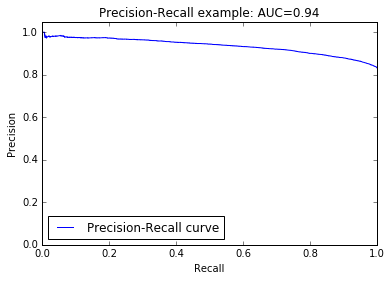

In [28]:
%matplotlib inline 
y_score = lr.decision_function(eval_res['X_test'])
y_test = eval_res['y_test']
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

#### An AUC of 0.94 as above, indicates that the model fits the data well, by choosing appropriate threshold for predicton we can achieve the desired precision, as well as recall

In [35]:
cf = pd.DataFrame({'precision':precision[1:], 'recall':recall[1:], 'threshold':threshold})

In [38]:
cf.query ('precision > 0.85 and recall > 0.85')

,precision,recall,threshold
727,0.850003,0.978238,-0.002078
732,0.850018,0.977958,0.008895
733,0.850070,0.977958,0.008918
734,0.850061,0.977888,0.009083
735,0.850113,0.977888,0.009409
736,0.850103,0.977818,0.009525
737,0.850155,0.977818,0.010660
738,0.850146,0.977748,0.010797
739,0.850137,0.977678,0.011047
740,0.850189,0.977678,0.011688


#### Any of the threshold values from above table will yeild a precision and recall > 0.85